# K-mer Evolution Notebook

- HDBSCAN github errors!
    - need to find version without problems
    - if now finding one revert back to MA version
- better inclusion of R, N, ... in the kmer
    - status: finished
- evolution on reading frame
    - difficult, ORF notebook necessary for it
- status: unfinished

In [1]:
from kneed import DataGenerator, KneeLocator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools as it
from Bio import SeqIO
from Bio.Seq import Seq
import math
import re
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
import hdbscan
from scipy.signal import savgol_filter

In [2]:
class Frequency(object):
    
    def __init__(self, k = 7, split = None, segment = None, quality = None, qualpos = 0, segpos = 0, variable = 0.9):
    
        self.k = k
        self.qualpos = qualpos
        self.segpos = segpos
        self.split = split
        self.segment = segment
        self.quality = quality
        self.variable = variable
        
        self.nucleotides = ['A', 'C', 'G', 'T']
        self.substit = dict.fromkeys(map(ord, self.nucleotides), None)
        self.exist = dict.fromkeys(map(''.join, it.product(self.nucleotides, repeat = self.k)), 0)        
        self.col = len(self.exist.keys())
        
        self.amino = {
            'AAA':'K', 'AAC':'N', 'AAG':'K', 'AAT':'N',
            'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
            'AGA':'R', 'AGC':'S', 'AGG':'R', 'AGT':'S',
            'ATA':'I', 'ATC':'I', 'ATG':'M', 'ATT':'I',
            'CAA':'Q', 'CAC':'H', 'CAG':'Q', 'CAT':'H',
            'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
            'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
            'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
            'GAA':'E', 'GAC':'D', 'GAG':'E', 'GAT':'D',
            'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
            'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
            'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',    
            'TAA':'Y', 'TAC':'*', 'TAG':'*', 'TAT':'Y',
            'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
            'TGA':'*', 'TGC':'C', 'TGG':'W', 'TGT':'C',
            'TTA':'L', 'TTC':'F', 'TTG':'L', 'TTT':'F',
        }
        self.nucex = {
            'A':['A'],
            'C':['C'],
            'G':['G'],
            'T':['T'],
            'R':['A', 'G'],
            'Y':['C', 'T'],
            'W':['A', 'T'],
            'S':['C', 'G'],
            'M':['A', 'C'],
            'K':['G', 'T'],
            'B':['G', 'C', 'T'],
            'H':['A', 'C', 'T'],
            'D':['A', 'G', 'T'],
            'V':['A', 'C', 'G'],
            'N':['A', 'C', 'G', 'T'],
        } 
        self.nucmut = {
            'A':['C', 'G', 'T'],
            'C':['A', 'G', 'T'],
            'G':['A', 'C', 'T'],
            'T':['A', 'C', 'G'],
        } 
    
    def checkup(self, name):
        
        try:
            if self.segment and self.quality:    
                head = name.split(self.split)
                if re.match(self.segment, head[self.segpos], re.IGNORECASE) and re.match(self.quality, head[self.qualpos], re.IGNORECASE):
                    return(True)
                else:
                    return(False)

            elif self.segment or self.quality:
                head = name.split(self.split)
                
                if e.match(self.segment, head[self.segpos], re.IGNORECASE) or re.match(self.quality, head[self.qualpos], re.IGNORECASE):
                    return(True)
                else:
                    return(False)

            else:
                return(True)
        except:
            return(False)
            
    def countRows(self, infile):
        
        row = 0
        for entry in SeqIO.parse(infile,'fasta'):
            
            name = entry.name
            sequence = str(entry.seq)
            missing = len(sequence.translate(self.substit))
            fracture = float(len(sequence)/missing) if missing else 0 
            
            if self.checkup(name) == True and fracture <= self.variable:
                row += 1
                
        return(row)
    
    def calculateFrequence(self, infile):
        
        row = self.countRows(infile)
        index = np.empty(row, dtype = 'object')
        matrix = np.empty((row, self.col, ),dtype = 'float32')
        
        pos = 0
        for entry in SeqIO.parse(infile,'fasta'):
            
            name = entry.name
            sequence = str(entry.seq)
            accession = name.split(self.split)[0]
            missing = len(sequence.translate(self.substit))
            fracture = float(len(sequence)/missing) if missing else 0 
            
            if self.checkup(name) == True and fracture <= self.variable:
                for i in range(len(sequence) - self.k + 1):
                    
                    kmer = sequence[i:i+self.k]
                    
                    if fracture == 0:
                        main = [kmer]
                        size = 1
                    else:
                        main = map(''.join, it.product(*[self.nucex.get(j) for j in kmer]))
                        size = np.prod([len(self.nucex.get(k)) for k in kmer])
                        
                    for sub in main:
                        self.exist[sub] += float(1/size)
                    #    self.exist[sub] += float((1-self.mutfac)/size)     
                    #    for l, nuc in enumerate(sub):
                    #        for mutation in map(''.join, it.product(*[[sub[:l]], self.nucmut.get(nuc), [sub[l+1:]]])):
                    #            self.exist[mutation] += float(self.mutfac/(size*12))

                matrix[pos] = np.fromiter(self.exist.values(), dtype = 'float32', count = self.col)/sum(self.exist.values())
                index[pos] = accession
                
                self.exist.update((k,0) for k in self.exist.keys())
                pos += 1
            
        return(index, matrix)

In [3]:
freq = Frequency(
    k = 7, 
    split = '|', 
    segment = '4', 
    quality = 'Pass', 
    qualpos = 8, 
    segpos = 2, 
    variable = 0.9)
index, matrixl1 = freq.calculateFrequence('A.fasta')

In [4]:
pca = PCA(n_components=50)
matrixpca = pca.fit_transform(matrixl1)
variance = pca.explained_variance_ratio_.sum()

In [5]:
matrixl2 = normalize(matrixpca, norm='l2')

In [6]:
hdbhierarch = hdbscan.HDBSCAN(
    min_samples = 1,
    min_cluster_size = 2,
    gen_min_span_tree=True,
    metric = 'euclidean',
).fit(matrixl2)

pdlink = hdbhierarch.single_linkage_tree_.to_pandas()
label = hdbhierarch.labels_

In [8]:
def getClusternumber (pdlink, t = 500, l = 10, savgol = True, w = 50):

    nplink = pdlink.drop(columns=['parent']).to_numpy()
    
    y = nplink[:, 2][::-1][:t]
    x = np.arange(1, len(y) + 1)
    
    if savgol == True:
        yhat = savgol_filter(y, w+1, 3)
        #ynorm = yhat / yhat.max()
        ynorm = yhat
    
    else:
        #ynorm = y / y.max()
        ynorm = y
    
    xnorm = x
    #xnorm = x / x.max()
    l = 1
    zsize = len(ynorm)
    z = np.empty(zsize, dtype = 'float32')
    z[:l] = -1
    z[zsize-l:] = -1

    for i in range(l,zsize-l):

        a = np.array([xnorm[i-l], ynorm[i-l]])
        b = np.array([xnorm[i], ynorm[i]])
        c = np.array([xnorm[i+l], ynorm[i+l]])

        ba = a - b
        bc = c - b

        cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
        #angle = np.arccos(cosine_angle)
        z[i] = cosine_angle#np.degrees(angle)
        
    return(z.max(), z.argmax())

In [9]:
getClusternumber(pdlink , t = 1000)

(-0.9999896, 25)

In [10]:
nplink = pdlink.drop(columns=['parent']).to_numpy()

y = nplink[:, 2][::-1]
x = np.arange(1, len(y) + 1)

In [11]:
print(y[916], y[926], y[936])

0.10264853852438559 0.1023291738217375 0.10206920019875247


In [12]:
print(y[20], y[30], y[40])

0.48268261852606215 0.4225595431517627 0.337130700332617


In [13]:
print(y[64], y[74], y[84])

0.2567163170768908 0.24247499292760816 0.23565083972962558


In [14]:
a = np.array([0, 0.35])
b = np.array([1, 0.5])
c = np.array([2, 0.15])

ba = a - b
bc = c - b

np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))

-0.8844115089390092

In [17]:
cluster_df = matrixl2

# parameter tuning for eps
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(cluster_df)
distances, indices = neighbors.kneighbors(cluster_df)
distances = np.sort(distances[:,10], axis=0)
i = np.arange(len(distances))

Text(0, 0.5, 'Distance')

<Figure size 360x360 with 0 Axes>

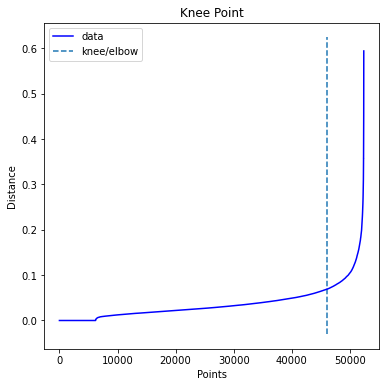

In [19]:
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

In [645]:
print(distances[knee.knee])

0.068784796
